# Training and Tuning Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from data_preprocessing import *
from model import *
from train import *
from utils import *

## GPU and Mixed Precision Setup

In [2]:
gpu_setup()
mixed_precision_setup()

Some of your GPUs may run slowly with dtype policy mixed_float16 because they do not all have compute capability of at least 7.0. Your GPUs:
  Tesla V100S-PCIE-32GB, compute capability 7.0
  Tesla V100-PCIE-32GB, compute capability 7.0
  Tesla P100-PCIE-16GB, compute capability 6.0 (x2)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [3]:
data_folder = 'data'
src_folder = 'raw'
dst_folder = 'processed'
dataset = 'mri_dataset'
train_folder = 'train'
test_folder = 'test'
train_label = 'train_label.csv'

## Image Enhancement Visualisation

Visualise enhanced images with varying hyperparameters.

Run ```bash prepare_dataset.sh``` to enhance image with the desired parameters and generate the tensorflow dataset

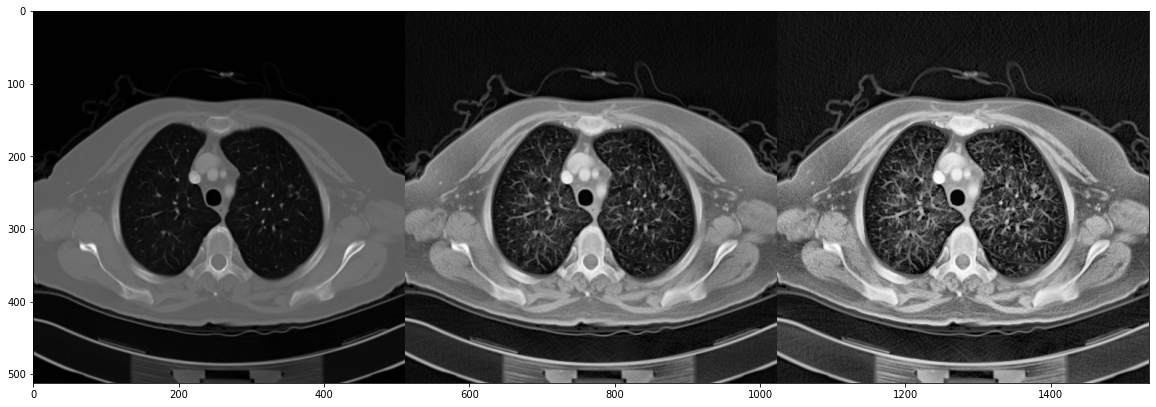

In [6]:
from image_enhancement import *


img_path = os.path.join(data_folder, src_folder, train_folder, '851.png')
img = cv.imread(img_path)
n_img = hist_norm(img)
clahe_img1 = clahe(img, clipLimit=4, tileGridSize=(8, 8))
clahe_img2 = clahe(img, clipLimit=8, tileGridSize=(8, 8))

# n_clahe_img = clahe(n_img, clipLimit=clip, tileGridSize=tile_size)
combined_imgs = np.hstack((img, clahe_img1, clahe_img2))
plt.figure(figsize=(20, 20))
plt.imshow(combined_imgs)

## Load Dataset

In [5]:
import tensorflow_datasets as tfds
from datasets.mri_dataset import MriDataset
from tensorflow.data import Dataset

SEED = 0

experiment_name = 'MobileNetV2'
model_params = {
    'model_type': 'mobile',
    'head_type': 'standard',
    'image_shape': (512, 512, 3),
    'num_classes': 3,
}
base_hyperparams = {
    'train_batch_size': 64,
    'valid_batch_size': 64,
    'test_batch_size': 64,
    'num_epochs': 1,
    'learning_rate': 1e-4,
    'dropout': 0.2
}
fine_hyperparams = {
    'num_epochs': 1,
    'learning_rate': 1e-5,
    'fine_tune_at': 100,
}

tf.random.set_seed(SEED)

train_folds = tfds.load(
    name='mri_dataset', 
    split=[f'train[:{k}%]+train[{k+10}%:]' for k in range(0, 100, 20)],
    download=False, 
    shuffle_files=False, 
    as_supervised=True,
    data_dir=data_folder
)
valid_folds = tfds.load(
    name='mri_dataset', 
    split=[f'train[{k}%:{k+10}%]' for k in range(0, 100, 20)],
    download=False, 
    shuffle_files=False, 
    as_supervised=True,
    data_dir=data_folder
)
test_ds_raw, test_info_raw = tfds.load(
    name='mri_dataset', 
    split='test', 
    download=False, 
    shuffle_files=False, 
    as_supervised=False, 
    with_info=True,
    data_dir=data_folder
)

train_folds = [ preprocess(ds, model_params, batch_size=base_hyperparams['train_batch_size'], ds_type='train') for ds in train_folds ]
valid_folds = [ preprocess(ds, model_params, batch_size=base_hyperparams['valid_batch_size'], ds_type='valid') for ds in valid_folds ]
test_ds = preprocess(test_ds_raw, model_params, batch_size=base_hyperparams['test_batch_size'], ds_type='test')

In [6]:
train_valid_df = pd.read_csv(os.path.join(data_folder, processed_folder, train_label))
train_ds = train_folds[0]
valid_ds = valid_folds[0]

print(f'Number of train batches: {train_ds.cardinality()}')
print(f'Number of valid batches: {valid_ds.cardinality()}')
print(f'Number of test batches: {test_ds.cardinality()}')

Number of train batches: 17
Number of valid batches: 2
Number of test batches: 5


## TODO: Visualise Dataset

In [7]:
# # disable image resize and rescale in preprocess function ONLY for visualisation
# # Train Data
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(9):
#     for i in range(9):
#       ax = plt.subplot(3, 3, i + 1)
#       plt.imshow(images[i].numpy().astype("uint8"))
#       plt.title(labels[i].numpy())
#       plt.axis("off")

In [8]:
# # Test Data
# plt.figure(figsize=(10, 10))
# for i, ds in enumerate(test_ds_raw.take(9)):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(ds['image'].numpy().astype("uint8"))
#     plt.title('ID: {}'.format(ds['id'].numpy()))
#     plt.axis("off")

In [9]:
# TODO: Fix visualisation
# data_augmentation = create_augmentation_layer()

# for image, _ in train_ds.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

## K-Fold Cross Validation

Tune hyperparameters.

In [10]:
tf.random.set_seed(SEED)

models = cross_validate(experiment_name, train_folds, valid_folds, model_params, base_hyperparams, fine_hyperparams)

# -------------------- MobileNetV2: 1-fold -------------------- #
 1/17 [>.............................] - ETA: 0s - loss: 1.3970 - accuracy: 0.1875WARNING:tensorflow:From /home/zongsien/MedicalImageClassifier/env/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
17/17 [==============================] - 10s 559ms/step - loss: 1.2542 - accuracy: 0.2700 - val_loss: 1.0947 - val_accuracy: 0.4224
Number of layers in the base model:  155
Epoch 2/2
17/17 [==============================] - 5s 321ms/step - loss: 0.9310 - accuracy: 0.5630 - val_loss: 0.7624 - val_accuracy: 0.7155
MobileNetV2 | Train Loss: 0.9309787750244141 | Train Accuracy: 0.5629770755767822 | Validation Loss: 0.7623521089553833 | Validation Accuracy: 0.715517222881

## Train Model with Best Parameters

Train the cross validated model with the best parameters on entire train dataset and save the model.

In [11]:
train_ds = train_folds[0].concatenate(valid_folds[0])
valid_ds = valid_folds[0] # dummy

model = feature_extract_and_fine_tune(experiment_name, train_ds, valid_ds, model_params, base_hyperparams, fine_hyperparams)
predicted_labels = evaluate(model, test_ds)
img_ids = tfds.as_dataframe(test_ds_raw, test_info_raw)
save_results(img_ids, predicted_labels, result_save_path)

print('Saving model\n')
filename = os.path.join('models', experiment_name, '.h5')
model.save(filename)

19/19 [==============================] - 4s 212ms/step - loss: 1.2057 - accuracy: 0.4081 - val_loss: 1.2271 - val_accuracy: 0.3017
Number of layers in the base model:  155
Epoch 2/2
19/19 [==============================] - 6s 337ms/step - loss: 0.8992 - accuracy: 0.6014 - val_loss: 0.7652 - val_accuracy: 0.7069


NameError: name 'result_save_path' is not defined

# TODO: Train Ensemble

In [12]:
# tf.random.set_seed(SEED)
# hyperparams = {
#     'initial_epochs': 150,
#     'learning_rate': 1e-4,
#     'label_smoothing': 0.1,
# }
# experiment_name = f'Ensemble02'


# ensemble_model = create_ensemble_model()
# train_ds = ensemble_input(train_folds[3], ds_type='train')
# valid_ds = ensemble_input(valid_folds[3], ds_type='valid')
# ensemble_model = train_validate(ensemble_model, train_ds, valid_ds, hyperparams, experiment_name)


In [13]:
# test_ds = ensemble_input(test_ds, ds_type='train')
# predictions = ensemble_model.predict(test_ds)
# predicted_indices = tf.argmax(predictions, 1)
# predicted_labels = predicted_indices.numpy()
# img_ids = tfds.as_dataframe(test_ds_raw, test_info_raw)
# save_results('Ensemble02_submission.csv', img_ids, predicted_labels)
# print('done')

# Feature Extraction + Fine Tuning Script

In [1]:
import tensorflow_datasets as tfds
from datasets.mri_dataset import MriDataset
from data_preprocessing import *
from model import *
from train import *
from utils import *

data_folder = 'data'
raw_folder = 'raw'
processed_folder = 'processed'
dataset = 'mri_dataset'
train_folder = 'train'
test_folder = 'test'
train_label = 'train_label.csv'

SEED = 0

experiment_name = 'MobileNetV2'
result_save_path = experiment_name + '_' + 'submission.csv'
model_params = {
    'model_type': 'mobile',
    'head_type': 'standard',
    'image_shape': (512, 512, 3),
    'num_classes': 3,
}
base_hyperparams = {
    'train_batch_size': 64,
    'valid_batch_size': 64,
    'test_batch_size': 64,
    'num_epochs': 1,
    'learning_rate': 1e-4,
    'dropout': 0.2
}
fine_hyperparams = {
    'num_epochs': 1,
    'learning_rate': 1e-5,
    'fine_tune_at': 100,
}

tf.random.set_seed(SEED)
gpu_setup()
mixed_precision_setup()

train_folds = tfds.load(
    name='mri_dataset', 
    split=[f'train[:{k}%]+train[{k+10}%:]' for k in range(0, 100, 20)],
    download=False, 
    shuffle_files=False, 
    as_supervised=True,
    data_dir=data_folder
)
valid_folds = tfds.load(
    name='mri_dataset', 
    split=[f'train[{k}%:{k+10}%]' for k in range(0, 100, 20)],
    download=False, 
    shuffle_files=False, 
    as_supervised=True,
    data_dir=data_folder
)
test_ds_raw, test_info_raw = tfds.load(
    name='mri_dataset', 
    split='test', 
    download=False, 
    shuffle_files=False, 
    as_supervised=False, 
    with_info=True,
    data_dir=data_folder
)

train_ds =  preprocess(train_folds[0], model_params, batch_size=base_hyperparams['train_batch_size'], ds_type='train')
valid_ds = preprocess(valid_folds[0], model_params, batch_size=base_hyperparams['valid_batch_size'], ds_type='valid')
test_ds = preprocess(test_ds_raw, model_params, batch_size=base_hyperparams['test_batch_size'], ds_type='test')

model = feature_extract_and_fine_tune(experiment_name, train_ds, valid_ds, model_params, base_hyperparams, fine_hyperparams)
predicted_labels = evaluate(model, test_ds)
img_ids = tfds.as_dataframe(test_ds_raw, test_info_raw)
save_results(img_ids, predicted_labels, result_save_path)

Some of your GPUs may run slowly with dtype policy mixed_float16 because they do not all have compute capability of at least 7.0. Your GPUs:
  Tesla V100S-PCIE-32GB, compute capability 7.0
  Tesla V100-PCIE-32GB, compute capability 7.0
  Tesla P100-PCIE-16GB, compute capability 6.0 (x2)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
 1/17 [>.............................] - ETA: 0s - loss: 1.3552 - accuracy: 0.1875WARNING:tensorflow:From /home/zongsien/MedicalImageClassifier/env/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
use `tf.profiler.experimental.stop

# TODO: Ensemble Learning Script

In [17]:
# TODO: refactor preprocess to enhance image
# TODO: Rename mri to lung_ct dataset
# TODO: Whole flow
    # enhance images
    # create dataset
    # load data
    # train
    # evaluate
# TODO: Ensemble flow